In [54]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, date
from meteostat import Stations, Daily, Hourly
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import tensorflow as tf
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import requests
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

In [16]:
# Retrieve Strava activity data as JSON response
auth_url = "https://www.strava.com/oauth/token"
activites_url = "https://www.strava.com/api/v3/athlete/activities"

payload = {
    'client_id': "<CLIENT_ID_HERE>",
    'client_secret': '<CLIENT_SECRET_HERE>',
    'refresh_token': '<REFRESH_TOKEN_HERE>',
    'grant_type': "refresh_token",
    'f': 'json'
}

# First API call to request access token
# Access tokens expire, so this saves you manual work of regenerating access tokens manually
print("Requesting Token...\n")
res = requests.post(auth_url, data=payload, verify=False)
access_token = res.json()['access_token']
print("Access Token = {}\n".format(access_token))

# Make API request to retrieve the last 400 activities
header = {'Authorization': 'Bearer ' + access_token}
param1 = {'per_page': 200, 'page': 1}
param2 = {'per_page': 200, 'page': 2}
param3 = {'per_page': 200, 'page': 3}
param4 = {'per_page': 200, 'page': 4}
my_dataset1 = requests.get(activites_url, headers=header, params=param1).json()
my_dataset2 = requests.get(activites_url, headers=header, params=param2).json()
my_dataset3 = requests.get(activites_url, headers=header, params=param3).json()
my_dataset4 = requests.get(activites_url, headers=header, params=param4).json()

print(my_dataset1[0]["name"])
print(my_dataset1[0]["map"]["summary_polyline"])

print(my_dataset2[0]["name"])
print(my_dataset2[0]["map"]["summary_polyline"])

print(my_dataset3[0]["name"])
print(my_dataset3[0]["map"]["summary_polyline"])

print(my_dataset4[0]["name"])
print(my_dataset4[0]["map"]["summary_polyline"])

Requesting Token...

Access Token = 799f805922656a4d3cc390e7fd109eeb722c5e10

Snowshoeing in Cliftons in Vienna ⛄️
}lkeHwotbBEAHEFSjCsBhAiAR[RKh@qBVyBDs@JYJs@XyBRa@PQBGJiAPeABkABOHg@JYNy@N_BPoAFI^?dCVRTb@LxADLSXq@R}@R{BAI@a@NWPy@j@uBFm@Nw@NoAJg@JaAA[Rk@Di@@m@JwAAu@XYXCl@LHLZI^C`@JJC`@Dt@Vb@ATEN@BDLAHEHS@}@AGFuBFs@Ji@Ia@C_AFk@HgCD]Ny@@aBBm@Jw@EsBDyAFm@Dy@DGBq@Cy@BUCsAN}Bb@i@Vo@LQTI\SZKZYVc@jC}Fp@_A^]LoAj@_Ap@}AX_@Xk@j@kB`@c@Vk@tAuAr@cBp@iAd@SbAsA\c@JGZe@bAcAh@Qb@]n@K^ORa@z@u@\c@p@[H[Es@SiA[aEy@{BO{@Sk@AILo@DEJ?Zg@~@YFGWyB[wAg@iCKcAO]Ii@Ma@OuAKa@Sc@e@yBi@wASo@Q}@k@eA_@gAa@a@]_AWs@MIcAmBIIKV]Z{Aj@{@H}ATwAJuC?a@AsBByACiBRqCbAsBfAuA`Aq@j@oAbBaA~Ak@bAU~@]d@m@\iCxCoCnBsDhBuBrAqG|Cy@PyEX_C@aBCwAGe@KYQ[A_B]c@Wc@MQAaCg@sAk@a@CMKwDgBwDkAqAy@MQuAw@gBkAqAeAaAo@c@_@_Ai@qA_AyAaAk@e@e@[iC}BUK]a@UMa@a@QYLBv@~@?DaAfC_ApDAxAW|EBx@Nl@Dh@?xDN|AX`@@XHT\b@@NGP@\Rh@EjA@^ClDJtCAr@@v@Id@CzAJt@?n@Bd@GFAf@FnAAv@N|B[`CUr@O|@Qz@OtAK|CDjDDt@@jACrBAt@Iz@Br@QvA?j@NDXXHAVBf@P~ARbA\f@D|Cr@FDg@vBCp@YxDNGz@d@d@h@B?h@p@Rl@

In [17]:
# Flatten nested JSON response into a Dataframe
activities1 = pd.json_normalize(my_dataset1)
activities2 = pd.json_normalize(my_dataset2)
activities3 = pd.json_normalize(my_dataset3)
activities4 = pd.json_normalize(my_dataset4)

# Combine into one dataframe
activities = pd.concat([activities1, activities2, activities3, activities4])
activities = activities.reset_index()
activities = activities.drop(columns=["index"])

print("Dataframe shape: ", activities.shape, "\n")
print("Dataframe columns: \n", activities.columns)

Dataframe shape:  (800, 55) 

Dataframe columns: 
 Index(['resource_state', 'name', 'distance', 'moving_time', 'elapsed_time',
       'total_elevation_gain', 'type', 'sport_type', 'workout_type', 'id',
       'start_date', 'start_date_local', 'timezone', 'utc_offset',
       'location_city', 'location_state', 'location_country',
       'achievement_count', 'kudos_count', 'comment_count', 'athlete_count',
       'photo_count', 'trainer', 'commute', 'manual', 'private', 'visibility',
       'flagged', 'gear_id', 'start_latlng', 'end_latlng', 'average_speed',
       'max_speed', 'average_cadence', 'has_heartrate', 'average_heartrate',
       'max_heartrate', 'heartrate_opt_out', 'display_hide_heartrate_option',
       'elev_high', 'elev_low', 'upload_id', 'upload_id_str', 'external_id',
       'from_accepted_tag', 'pr_count', 'total_photo_count', 'has_kudoed',
       'suffer_score', 'athlete.id', 'athlete.resource_state', 'map.id',
       'map.summary_polyline', 'map.resource_state', 'ave

In [18]:
# Flag race activities
# only keep run activties
running_activities = activities.loc[activities["type"] == "Run"]
running_activities = running_activities.drop(columns=["type"])
running_activities["race"] = False

# manually mark race activities as "race"=True
# Races: 11-11-2023 , 2-19-2023, 1-22-2023, 2-27-2022, 1-23-2022, 5-6-2023, 11-24-2022, 12-4-2022
# Relays: 3-28-2021, 3-27-2021, 3-27-2021, 3-26-2023, 3-25-2023, 3-25-2023, 8-26-2023, 8-25-2023, 8-25-2023
# NOT in current data pull -  1-23-2022, 2-27-2022, 3-28-2021, 3-27-2021, 3-27-2021
race_activity_ids = [10270133740,10201538669,8589932304,8434045492,9022328776,8162552673,8207198428]
relay_activity_ids = [8779880223,8777939900,8776825449,9721567283,9719999180,9725419043]

# uncomment to locate race activities and retrieve ids
#display(running_activities.loc[(pd.to_datetime(running_activities["start_date_local"])).dt.date == date(2023,11,23)])
#display(running_activities.loc[running_activities.id == 10201538669])

for id in race_activity_ids:
        running_activities.loc[running_activities.id == id, "race"] = True        

race_activities = running_activities.loc[running_activities["race"] == True]
display(race_activities)

,resource_state,name,distance,moving_time,elapsed_time,total_elevation_gain,sport_type,workout_type,id,start_date,...,total_photo_count,has_kudoed,suffer_score,athlete.id,athlete.resource_state,map.id,map.summary_polyline,map.resource_state,average_temp,race
5,2,Seattle Turkey Trot 15k 🦃,15251.8,3903,3903,36.3,Run,0.0,10270133740,2023-11-23T17:31:57Z,...,2,False,226.0,42128847,1,a10270133740,ss_bHjjciVcBcAgCq@mETsBxAuFjE]^e@bAAl@XTf@JjAF...,2,NaN,True
13,2,Richmond Marathon 2023,42360.6,10966,11140,198.3,Run,0.0,10201538669,2023-11-11T12:00:10Z,...,5,False,508.0,42128847,1,a10201538669,w_ddFretwMwBnEqChFmCvEq@~AwInQqDpGmCbGaFhJ}LzV...,2,NaN,True
221,2,Yosemite Half Marathon (see race highlights be...,20935.9,5372,5510,167.9,Run,0.0,9022328776,2023-05-06T13:01:35Z,...,1,False,194.0,42128847,1,a9022328776,yaxbFd_vxUFfBS|BaCvKGn@TvBAr@a@vCe@j@{BFm@l@Nt...,2,NaN,True
302,2,Austin Half Marathon,21294.7,5384,5384,184.4,Run,0.0,8589932304,2023-02-19T13:04:04Z,...,3,False,224.0,42128847,1,a8589932304,aavwDbtqsQbAH\Pj@Dt@`@vAh@Z\tH`Br@TtG~AnDrAj@B...,2,NaN,True
337,2,3M Half Marathon,21267.1,5192,5192,52.7,Run,0.0,8434045492,2023-01-22T13:31:17Z,...,2,False,237.0,42128847,1,a8434045492,gfnxD~qpsQoAbASBo@@o@ZgATgBF{CUuA?o@JyABm@NcAH...,2,NaN,True
381,2,SA Rock ‘n Roll,21294.8,5347,5394,83.7,Run,0.0,8207198428,2022-12-04T13:04:09Z,...,4,False,187.0,42128847,1,a8207198428,q`rrDffdxQmAAs@Ok@EeBJq@MkCCGA[]Fo@AUMi@GeA@k@...,2,NaN,True
390,2,Turkey trot - race edition,5113.7,1158,1158,12.0,Run,0.0,8162552673,2022-11-24T14:31:51Z,...,1,False,27.0,42128847,1,a8162552673,g`agE`dxmQ@_@Ck@]cCI_@Uc@m@o@o@i@k@o@e@yAKg@AQ...,2,NaN,True


In [19]:
# Helper functions
def ft_to_meters(dist_ft):
    return dist_ft * 0.3048

def miles_to_meters(dist_miles):
    return dist_miles * 1609.34

def z_score(df, col_name):
    df2 = df.copy()
    df2[col_name] = ( (df[col_name] - df[col_name].mean()) / df[col_name].std() )
    return df2

def normalize(df, col_name):
    df2 = df.copy()
    df2[col_name] = ( (df2[col_name] - df2[col_name].min()) / (df2[col_name].max() - df2[col_name].min()) )
    return df2

def seconds_to_timedelta(seconds):
    minutes, seconds = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)

    return str("%d:%02d:%02d" % (hours, minutes, seconds))

def min_per_mile(seconds, pace):
    
    return
    
    
# Check distribution of numeric columns to decide proper encoding method
def plot_elev_high(df):
    df["elev_high"].plot(kind="hist", title="Elevation High Distribution")
    print("elev_high mean:",df["elev_high"].mean(),"\nelev_high std distribution:",df["elev_high"].std())
    
def plot_avg_temp(df):
    df["avg_temp"].plot(kind="hist", title="Average Temperature Distribution")
    print("avg_temp mean:",df["avg_temp"].mean(),"\navg_temp std distribution:",df["avg_temp"].std())
    
def plot_avg_cadence(df):
    df["average_cadence"].plot(kind="hist", title="Average Cadence Distribution")
    print("average_cadence mean:",df["average_cadence"].mean(),"\naverage_cadence std distribution:",df["average_cadence"].std())

def plot_max_hr(df):
    df["max_heartrate"].plot(kind="hist", title="Maximum Heartrate Distribution")
    print("max_heartrate mean:",df["max_heartrate"].mean(),"\nmax_heartrate std distribution:",df["max_heartrate"].std())

def plot_avg_hr(df):   
    df["average_heartrate"].plot(kind="hist", title="Average Heartrate Distribution")
    print("average_heartrate mean:",df["average_heartrate"].mean(),"\naverage_heartrate std distribution:",df["average_heartrate"].std())

def plot_max_speed(df):
    df["max_speed"].plot(kind="hist", title="Maxiumum Speed Distribution")
    print("max_speed mean:",df["max_speed"].mean(),"\nmax_speed std distribution:",df["max_speed"].std())

def plot_elev_gain(df):
    df["total_elevation_gain"].plot(kind="hist", title="Total Elevation Gain Distribution")
    print("total_elevation_gain mean:",df["total_elevation_gain"].mean(),"\ntotal_elevation_gain std distribution:",df["total_elevation_gain"].std())

In [20]:
def handle_nulls(df, method):
    if method == "interpolation":
        df = df.interpolate()
        return df

def handle_nulls_race(input_df, training_df):
    race_activities = training_df.loc[training_df["race"] == True]
    display(input_df)
    

In [21]:
# Retrieves weather data from a given set of locations (loc_df) across a date range (min_date -> max_date)
# Returns input timestamped dataframe (df) with an additional column, avg_temp
def get_weather(min_date, max_date, loc_df, df):

    # Get unique list of weather stations from locations
    print("Retrieving list of weather stations...")
    weather_stations = pd.DataFrame()
    loc_dict = {}
    for location in loc_df:
        stations = Stations()
        nearby_station = stations.nearby(location[0], location[1]).fetch(1)
        loc_dict[("[ "+str(location[0])+" "+str(location[1])+"]")] = nearby_station.index[0]
        weather_stations = pd.concat([weather_stations, nearby_station])

    weather_stations = weather_stations.drop_duplicates(subset='name')
    print("Weather stations retrieved.")
    display(weather_stations.head())
    
    # Retrieving Weather Data from Nearby Stations
    # Create dictionary to hold dataframes of weather data. Dict key is weather station id.
    print("Retrieving weather data...")
    weather_df_dict = {}
    for coord, station_id in loc_dict.items():
        weather_df_dict[station_id] = pd.DataFrame()
    
    # Retrieve at least a year of weather data
    today = date.today()
    last_year = today.year - 1
    a_year_ago_today = date(last_year, today.month, today.day)
    if a_year_ago_today < min_date:
        min_date = a_year_ago_today

    for idx, station in weather_stations.iterrows():
        # Daily Weather
        weather_df_dict[idx] = Daily(idx, start=datetime.combine(min_date, datetime.min.time()), end=datetime.combine(max_date, datetime.min.time())).fetch()

        # Hourly Weather
        #weather_df_dict[idx] = Hourly(idx, start=datetime.combine(min_date, datetime.min.time()), end=datetime.combine(max_date, datetime.min.time())).fetch()
    print("Weather data retrieved.")
    
    # Add weather data to loc_df
    print("Adding weather data to df...")
    
    # Add weather data to run_activities dataframe
    df["weather_station"] = None
    df["avg_temp"] = None

    for idx, activity in df.iterrows():
        dict_key = "[ " + str(activity['start_lat']) + " " + str(activity['start_lng']) + "]"
        if dict_key in loc_dict:
            weather_df = weather_df_dict[loc_dict[dict_key]]
            # check if date is in the future
            if today < activity["start_date_local"]:
                # if date is in future, use weather from last year
                new_date = date(activity["start_date_local"].year - 1, activity["start_date_local"].month, activity["start_date_local"].day)
                try:
                    df.at[idx,"weather_station"] = loc_dict[dict_key]
                    df.at[idx,"avg_temp"] = weather_df.loc[str(new_date)]["tavg"]
                except:
                    # weather not found for date / station
                    df.at[idx,"weather_station"] = loc_dict[dict_key]
                    df.at[idx,"avg_temp"] = np.nan
            try:
                df.at[idx,"weather_station"] = loc_dict[dict_key]
                df.at[idx,"avg_temp"] = weather_df.loc[str(activity["start_date_local"])]["tavg"]
            except:
                # weather not found for date / station
                df.at[idx,"weather_station"] = loc_dict[dict_key]
                df.at[idx,"avg_temp"] = np.nan
    
    print("Weather data added.")
    df = df.drop(labels=["weather_station"], axis=1)
    display(df.head())
                
    return df

In [34]:
# Returns df with encoded categorical and numeric columns.
def data_encoding(df, skip_encoding):
    df_encoded = df
    
    # encode time cyclically
    # split date time into seperate columns
    df_encoded.loc[:,"date-time"] = pd.to_datetime(df_encoded.start_date_local.astype(str)+ " " + df_encoded.start_time.astype(str ))
    df_encoded["year"] = df_encoded["date-time"].dt.year
    df_encoded["month"] = df_encoded["date-time"].dt.month
    df_encoded["day"] = df_encoded["date-time"].dt.day
    df_encoded["hour"] = df_encoded["date-time"].dt.hour
    df_encoded["min"] = df_encoded["date-time"].dt.minute
    df_encoded["sec"] = df_encoded["date-time"].dt.second
    df_encoded["total_seconds"] = df_encoded["hour"]*60*60 +  df_encoded["min"]*60 +  df_encoded["sec"]
    
    # cyclically encode date and time with sin / cos functions
    seconds_in_day = 24*60*60

    df_encoded["month_sin"] = np.sin(2*np.pi*df_encoded.month/12)
    df_encoded["month_cos"] = np.cos(2*np.pi*df_encoded.month/12)

    df_encoded["day_sin"] = np.sin(2*np.pi*df_encoded.day/31)
    df_encoded["day_cos"] = np.cos(2*np.pi*df_encoded.day/31)

    df_encoded["sec_sin"] = np.sin(2*np.pi*df_encoded.total_seconds/seconds_in_day)
    df_encoded["sec_cos"] = np.cos(2*np.pi*df_encoded.total_seconds/seconds_in_day)
    
    # one-hot encode year
    one_hot_year = pd.get_dummies(df_encoded["year"])
    df_encoded = df_encoded.join(one_hot_year)
    
    if not skip_encoding:
        # normalize or standardize numeric columns based on distribution of values (normal or not)
        df_encoded = z_score(df_encoded, "average_cadence")
        df_encoded = z_score(df_encoded, "average_heartrate")
        df_encoded = z_score(df_encoded, "max_heartrate")
        df_encoded = normalize(df_encoded, "total_elevation_gain")
        df_encoded = normalize(df_encoded, "elev_high")
        df_encoded = z_score(df_encoded, "max_speed")
        df_encoded = z_score(df_encoded, "avg_temp")

    
    # drop uncoded columns
    df_encoded = df_encoded.drop(columns=["date-time","year","month","day","hour","min","sec","total_seconds","start_time","start_date_local"])
    
    return df_encoded

In [29]:
def data_preprocessing(df, skip_encoding=False):
    
    # modify date/time/location columns
    df['start_date_local'] = pd.to_datetime(df['start_date_local'])
    df['start_time'] = df['start_date_local'].dt.time
    df['start_date_local'] = df['start_date_local'].dt.date
    df['start_lat'] = round(df['start_latlng'].str[0], 2)
    df['start_lng'] = round(df['start_latlng'].str[1], 2)
    df = df.drop(columns=['start_latlng'])
    
    # add weather data
    # if date is in future (i.e. for race prediction), get the weather from that location last year
    min_date, max_date = df['start_date_local'].min(), df['start_date_local'].max()
    locations = df.loc[:,['start_lat', 'start_lng']].drop_duplicates().values
    
    df = handle_nulls(df, "interpolation")
    df = get_weather(min_date, max_date, locations, df)
    df["avg_temp"].fillna((df["avg_temp"].mean()), inplace = True) # handle any null values in new avg_temp col
    df = df.drop(columns=['start_lat','start_lng'])
    print("How many nulls?") # verify there are no null values
    print(df.isnull().sum())
    df = data_encoding(df, skip_encoding)
    
    return df

In [65]:
# Model predicts moving time / average pace during a race based on race's location, elevation, and distance.
def race_predictor(model_training_df, input_param_dict, model_name):
    # Verify format of input parameters - race_date, start_latlng, distance, elev_gain, elev_high
    if len(input_param_dict) < 5:
        print("Missing input parameters. race_predictor is expecting a dictionary with keys: race_date, start_latlng, distance, elev_gain, elev_high.")
        return
    
    cols = ['start_date_local', 'start_latlng', 'distance', 'moving_time',  'total_elevation_gain', 'max_speed',
            'average_cadence', 'average_heartrate', 'max_heartrate', 'elev_high', 'race']
    model_training_df = model_training_df[cols]
    race_activities_df = model_training_df.loc[model_training_df["race"] == True]
    
    # populate input_df with avg values from other race activities
    input_df = pd.DataFrame( {
        "start_date_local": [input_param_dict["race_date"]],
        "start_latlng": [input_param_dict["start_latlng"]],
        "distance":  [miles_to_meters(input_param_dict["distance_miles"])],
        "moving_time": [None],
        "total_elevation_gain": [ft_to_meters(input_param_dict["elev_gain_ft"])],
        "max_speed": [race_activities_df["max_speed"].mean()],
        "average_cadence": [race_activities_df["average_cadence"].mean()],
        "average_heartrate": [race_activities_df["average_heartrate"].mean()],
        "max_heartrate": [race_activities_df["max_heartrate"].mean()],
        "elev_high": [ft_to_meters(input_param_dict["elev_high_ft"])],
        "race": True,
        "prediction": True}
                            
        )
    model_training_df["prediction"] = False
    print("Model Training DF:")
    display(model_training_df)

    # Create single df before pre-processing
    model_df = pd.concat([model_training_df, input_df])
    training_data = data_preprocessing(model_df)
    
    if model_name == "linear_reg":
        x_race = training_data.loc[training_data["prediction"] == True]
        x_train = training_data.loc[training_data["prediction"] == False]
        
        df = x_train.drop(columns=["moving_time","month_sin","month_cos","day_sin","day_cos"])
        x = np.array(x_train.drop(columns=["moving_time","month_sin","month_cos","day_sin","day_cos"]))
        y = np.array(x_train["moving_time"])
        
        # Build Multiple Linear Regression model with scikit-learn
        model = LinearRegression().fit(x,y)
        
        # Print model results
        r_sq = model.score(x,y)
        print(f"coefficient of determination: {r_sq}")
        print(f"intercept: {model.intercept_}")
        print()
        print(f"coefficients: {model.coef_}")

        # summarize feature importance
        importance = model.coef_
        for i,v in enumerate(importance):
            print('Feature: %0d, Score: %.5f' % (i,v))
        
        # plot feature importance
        plt.bar([x for x in range(len(importance))], importance)
        plt.show()
        
        # Use model to predict moving_time for race
        x_pred = np.array(x_race.drop(columns=["moving_time","month_sin","month_cos","day_sin","day_cos"]))
    
        y_pred = model.predict(x_pred)
        
        print("prediciton:",y_pred)
        
        print(seconds_to_timedelta(y_pred))

    elif model_name == "nn":

        device = (
            "cuda"
            if torch.cuda.is_available()
            else "mps"
            if torch.backends.mps.is_available()
            else "cpu"
        )

        print("Using {} device for nn training".format(device))

        # Define Neural Network
        class NeuralNetwork(nn.Module):
            def __init__(self, input_size):
                super().__init__()
                self.linear_relu_stack = nn.Sequential(
                    nn.Linear(input_size, 15),
                    nn.ReLU(),
                    nn.Linear(15,30),
                    nn.ReLU(),
                    nn.Linear(30,45),
                    nn.ReLU(),
                    nn.Linear(45,60),
                    nn.ReLU(),
                    nn.Linear(60,45),
                    nn.ReLU(),
                    nn.Linear(45,30),
                    nn.ReLU(),
                    nn.Linear(30,15),
                    nn.ReLU(),
                    nn.Linear(15,1),
                )
                
            def forward(self, x):
                x = x.to(torch.float32)
                logits = self.linear_relu_stack(x)
                return logits
                
        training_data['moving_time'] = training_data['moving_time'].astype(float)
        x_race = training_data.loc[training_data["prediction"] == True]
        x_train = training_data.loc[training_data["prediction"] == False]
        
        
        x = np.array(x_train.drop(columns=["moving_time"]))
        y = np.array(x_train["moving_time"])
 
        #TODO: incorporate dataloader
        
        model = NeuralNetwork(len(x[0]))
        model.to(device)
        opt = torch.optim.Adam(model.parameters())
        loss_func = nn.MSELoss()

        epochs = 10
        for epoch in range(epochs):
            print(f"Starting epoch {epoch}....")
            for x_item, y_item in zip(x, y):
                x_item = np.asarray(list(x_item))
                x_item = torch.from_numpy(x_item)
                y_item = torch.from_numpy(np.asarray([float(y_item)]))
                y_item_pred = model(x_item)
                loss = loss_func(y_item_pred, y_item.to(torch.float32))
                opt.zero_grad()
                loss.backward()
                opt.step()
        
        x_race_arr = np.array(x_race.drop(columns=["moving_time"]))
        x_race_item = np.array(list(x_race_arr[0]))
        x_race_item = torch.from_numpy(x_race_item) #TODO: fix
        y_race_pred = model(x_race_item)[0] #might have to feed in zeroth index
        moving_time_prediction = seconds_to_timedelta(y_race_pred.item())
        
        
    return "Predicted race time for {distance} mile race is {pred}".format(distance=input_param_dict["distance_miles"], pred=moving_time_prediction)


In [51]:
# Model Training data sets
marathon_test_stop = date(2023,11,11)
marathon_test_stop_idx = (running_activities.loc[running_activities.index[(pd.to_datetime(running_activities["start_date_local"])).dt.date == marathon_test_stop]]).index[0]
fifteenK_stop = date(2023,11,22)
fifteenK_stop_idx = (running_activities.loc[running_activities.index[(pd.to_datetime(running_activities["start_date_local"])).dt.date == fifteenK_stop]]).index[0]

marathon_test_activities = running_activities[marathon_test_stop_idx : -1]
fifteenK_test_activities = running_activities[fifteenK_stop_idx : -1]

display(marathon_test_activities.head())
display(fifteenK_test_activities.head())

,resource_state,name,distance,moving_time,elapsed_time,total_elevation_gain,sport_type,workout_type,id,start_date,...,total_photo_count,has_kudoed,suffer_score,athlete.id,athlete.resource_state,map.id,map.summary_polyline,map.resource_state,average_temp,race
15,2,Shake it out,6463.0,2128,2354,55.5,Run,0.0,10194282321,2023-11-10T14:52:33Z,...,0,False,38.0,42128847,1,a10194282321,s_ilFraruMYB?BIHa@JILCVT`@L`@h@hAb@x@Z`@`@G`@O...,2,NaN,False
16,2,Afternoon Run,8868.7,2791,3017,100.8,Run,NaN,10184937384,2023-11-08T19:29:36Z,...,0,False,54.0,42128847,1,a10184937384,aatwDrfrsQNRN[H@UPKROf@@F^TJBRR^b@^LLRF@FHHBHC...,2,NaN,False
17,2,Congress bats came out just to cheer my along ...,14664.8,4163,4896,138.5,Run,0.0,10179872931,2023-11-07T22:52:39Z,...,0,False,107.0,42128847,1,a10179872931,}}swDzfrsQfAz@FLWMmAQa@@k@RQXUJgDgAe@U_Bk@oCq@...,2,NaN,False
19,2,Ready for some givings w my friends 🦃,17733.1,4821,5456,141.3,Run,0.0,10167948372,2023-11-05T21:48:50Z,...,0,False,156.0,42128847,1,a10167948372,}~swDfgrsQg@Ne@ZCj@ORsIuCcJkCqFcAoRaFwAk@@GECs...,2,NaN,False
20,2,For the horns🤘🏼,8863.3,2593,2874,74.8,Run,0.0,10158800614,2023-11-04T13:07:49Z,...,0,False,48.0,42128847,1,a10158800614,iatwDjirsQGRWFO?aAi@s@UoBe@kAe@aBi@_@C]TQTQHOK...,2,NaN,False


,resource_state,name,distance,moving_time,elapsed_time,total_elevation_gain,sport_type,workout_type,id,start_date,...,total_photo_count,has_kudoed,suffer_score,athlete.id,athlete.resource_state,map.id,map.summary_polyline,map.resource_state,average_temp,race
6,2,Manager says log off early 🦃,8061.0,2699,2844,76.3,TrailRun,0.0,10264597941,2023-11-22T19:10:47Z,...,0,False,33.0,42128847,1,a10264597941,weebH`wxgV`An@dBj@q@o@F~@R~@n@D^MPb@j@h@VDFV\l...,2,NaN,False
7,2,Better than yesterday,9857.0,3392,3614,111.5,TrailRun,0.0,10258415903,2023-11-21T17:56:31Z,...,0,False,76.0,42128847,1,a10258415903,ghebHxyxgVBBXUbBe@TERDRnANd@R\z@S\l@PJFp@ZELLN...,2,NaN,False
8,2,Fighting a losing battle with my calf,6452.7,2521,2814,51.7,TrailRun,0.0,10252889734,2023-11-20T18:45:54Z,...,0,False,49.0,42128847,1,a10252889734,_hebHvxxgVxAYLGTEP@RHRNBXDx@Nb@ZDNEXQB@BT\\LNB...,2,NaN,False
9,2,A classic Washington welcome,12899.9,4366,5036,76.5,Run,0.0,10248228646,2023-11-19T19:31:37Z,...,1,False,91.0,42128847,1,a10248228646,whebH~yxgVWKcAA}Df@OOa@mAGy@WkAA}@DSVMzAXvAG`B...,2,NaN,False
10,2,Afternoon Run,8712.1,3163,3170,43.2,Run,NaN,10236722335,2023-11-17T23:36:21Z,...,0,False,14.0,42128847,1,a10236722335,q}swDpjrsQu@_@o@MW^a@KoAa@mA]]G_@Os@QcA_@eBe@[...,2,NaN,False


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,start_date_local,start_latlng,distance,moving_time,total_elevation_gain,max_speed,average_cadence,average_heartrate,max_heartrate,elev_high,race,prediction
15,2023-11-10T09:52:33Z,"[38.88138284906745, -77.10249150171876]",6463.0,2128,55.5,4.041,84.2,145.8,165.0,84.7,False,False
16,2023-11-08T13:29:36Z,"[30.254413532093167, -97.74713435210288]",8868.7,2791,100.8,5.486,80.7,147.2,164.0,203.2,False,False
17,2023-11-07T16:52:39Z,"[30.253916485235095, -97.74717961438]",14664.8,4163,138.5,7.044,81.9,153.4,178.0,186.0,False,False
19,2023-11-05T15:48:50Z,"[30.2540785074234, -97.7472332585603]",17733.1,4821,141.3,8.456,82.9,159.0,180.0,187.4,False,False
20,2023-11-04T08:07:49Z,"[30.254457034170628, -97.74757917970419]",8863.3,2593,74.8,6.339,82.5,145.2,163.0,172.6,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
794,2021-08-27T07:27:29Z,"[30.272565, -97.632663]",9666.5,3048,74.4,4.600,78.9,142.6,173.0,185.8,False,False
795,2021-08-26T18:04:04Z,"[30.301983, -97.698552]",9668.6,3068,40.8,4.100,77.4,140.8,161.0,189.5,False,False
796,2021-08-25T19:01:29Z,"[30.413111, -97.719967]",11280.3,3320,102.9,4.500,78.5,154.5,177.0,238.0,False,False
797,2021-08-24T19:06:32Z,"[30.274706, -97.764652]",8082.5,2307,58.6,5.600,80.9,145.4,183.0,152.5,False,False


,start_date_local,start_latlng,distance,moving_time,total_elevation_gain,max_speed,average_cadence,average_heartrate,max_heartrate,elev_high,race,prediction
15,2023-11-10T09:52:33Z,"[38.88138284906745, -77.10249150171876]",6463.000,2128,55.500,4.0410,84.20,145.80,165.0,84.7000,False,False
16,2023-11-08T13:29:36Z,"[30.254413532093167, -97.74713435210288]",8868.700,2791,100.800,5.4860,80.70,147.20,164.0,203.2000,False,False
17,2023-11-07T16:52:39Z,"[30.253916485235095, -97.74717961438]",14664.800,4163,138.500,7.0440,81.90,153.40,178.0,186.0000,False,False
19,2023-11-05T15:48:50Z,"[30.2540785074234, -97.7472332585603]",17733.100,4821,141.300,8.4560,82.90,159.00,180.0,187.4000,False,False
20,2023-11-04T08:07:49Z,"[30.254457034170628, -97.74757917970419]",8863.300,2593,74.800,6.3390,82.50,145.20,163.0,172.6000,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
795,2021-08-26T18:04:04Z,"[30.301983, -97.698552]",9668.600,3068,40.800,4.1000,77.40,140.80,161.0,189.5000,False,False
796,2021-08-25T19:01:29Z,"[30.413111, -97.719967]",11280.300,3320,102.900,4.5000,78.50,154.50,177.0,238.0000,False,False
797,2021-08-24T19:06:32Z,"[30.274706, -97.764652]",8082.500,2307,58.600,5.6000,80.90,145.40,183.0,152.5000,False,False
798,2021-08-23T18:56:14Z,"[30.286558, -97.742625]",11385.500,3307,93.800,8.6000,79.30,155.60,176.0,183.4000,False,False


Retrieving list of weather stations...
Weather stations retrieved.


,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end,distance
id,,,,,,,,,,,,,,,,
72405,Washington National Airport,US,DC,72405,KDCA,38.8500,-77.0333,5.0,America/New_York,1936-09-01,2023-11-26,1936-09-01,2023-11-20,1936-01-01,2022-01-01,6669.082961
72254,Camp Mabry/Austin City Asos,US,TX,72254,KATT,30.3167,-97.7667,201.0,America/Chicago,2000-01-01,2023-11-26,1938-06-01,2023-11-19,1938-01-01,2022-01-01,7588.073798
KTKI0,McKinney,US,TX,<NA>,KTKI,33.1779,-96.5905,179.0,America/Chicago,2006-01-01,2023-11-26,2006-01-01,2022-04-25,2006-01-01,2022-01-01,7402.455335
72253,San Antonio International Airport,US,TX,72253,KSAT,29.5333,-98.4667,247.0,America/Chicago,1946-08-14,2023-11-26,1946-08-14,2023-11-20,1946-01-01,2022-01-01,10454.051693
KAPA0,Denver / Dove Valley,US,CO,<NA>,KAPA,39.5701,-104.8493,1794.0,America/Denver,2006-01-01,2023-11-26,2006-01-01,2022-04-24,2006-01-01,2022-01-01,12660.544227


Retrieving weather data...
Weather data retrieved.
Adding weather data to df...
Weather data added.


,start_date_local,distance,moving_time,total_elevation_gain,max_speed,average_cadence,average_heartrate,max_heartrate,elev_high,race,prediction,start_time,start_lat,start_lng,avg_temp
15,2023-11-10,6463.0,2128,55.5,4.041,84.2,145.8,165.0,84.7,False,False,09:52:33,38.88,-77.10,11.9
16,2023-11-08,8868.7,2791,100.8,5.486,80.7,147.2,164.0,203.2,False,False,13:29:36,30.25,-97.75,22.9
17,2023-11-07,14664.8,4163,138.5,7.044,81.9,153.4,178.0,186.0,False,False,16:52:39,30.25,-97.75,22.8
19,2023-11-05,17733.1,4821,141.3,8.456,82.9,159.0,180.0,187.4,False,False,15:48:50,30.25,-97.75,19.6
20,2023-11-04,8863.3,2593,74.8,6.339,82.5,145.2,163.0,172.6,False,False,08:07:49,30.25,-97.75,19.0


How many nulls?
start_date_local        0
distance                0
moving_time             1
total_elevation_gain    0
max_speed               0
average_cadence         0
average_heartrate       0
max_heartrate           0
elev_high               0
race                    0
prediction              0
start_time              0
avg_temp                0
dtype: int64
HERE
TRAIONGON DTATA


,distance,moving_time,total_elevation_gain,max_speed,average_cadence,average_heartrate,max_heartrate,elev_high,race,prediction,avg_temp,month_sin,month_cos,day_sin,day_cos,sec_sin,sec_cos,2021,2022,2023
221,20935.900,5372,0.402734,0.642112,1.415494,1.370563,1.048537,0.402137,True,False,-0.606403,5.000000e-01,-0.866025,0.937752,0.347305,0.999976,-0.006909,False,False,True
302,21294.700,5384,0.442312,0.483805,0.781063,1.742852,0.753939,0.075154,True,False,-0.547939,8.660254e-01,0.500000,-0.651372,-0.758758,0.961181,-0.275917,False,False,True
337,21267.100,5192,0.126409,-0.152333,0.319659,2.047452,1.244936,0.094603,True,False,-1.155966,5.000000e-01,0.866025,-0.968077,-0.250653,0.921722,-0.387851,False,False,True
381,21294.800,5347,0.200768,1.328885,1.415494,1.381845,0.557540,0.086418,True,False,-0.793488,-2.449294e-16,1.000000,0.724793,0.688967,0.961081,-0.276266,False,True,False
390,5113.700,1158,0.028784,0.826028,2.972732,0.061913,-0.031657,0.051539,True,False,-0.851953,-5.000000e-01,0.866025,-0.988468,0.151428,0.788414,-0.615146,False,True,False
0,42164.708,None,0.358244,0.625699,1.380888,1.320925,0.714659,0.029557,True,True,-1.413209,-5.000000e-01,0.866025,0.790776,-0.612106,0.965926,-0.258819,False,False,True


Index([            'distance', 'total_elevation_gain',            'max_speed',
            'average_cadence',    'average_heartrate',        'max_heartrate',
                  'elev_high',                 'race',           'prediction',
                   'avg_temp',              'sec_sin',              'sec_cos',
                         2021,                   2022,                   2023],
      dtype='object')
coefficient of determination: 0.9817460978893083
intercept: 9.253923603562725

coefficients: [ 2.87013967e-01  6.00018269e+02 -2.25962869e+00 -9.78218491e+01
 -9.71678038e+01  1.53162044e+00  1.07013276e+02 -5.95234000e+02
 -4.93827201e-13  1.17096784e+01  2.05382980e+01 -4.88260656e+01
 -9.12421460e+00  5.17301022e+01 -4.26058876e+01]
Feature: 0, Score: 0.28701
Feature: 1, Score: 600.01827
Feature: 2, Score: -2.25963
Feature: 3, Score: -97.82185
Feature: 4, Score: -97.16780
Feature: 5, Score: 1.53162
Feature: 6, Score: 107.01328
Feature: 7, Score: -595.23400
Feature: 8, Scor

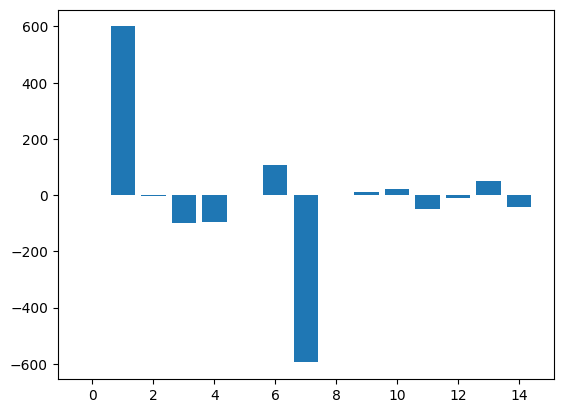

prediciton: [11443.56584408]
3:10:43


,distance,moving_time,total_elevation_gain,max_speed,average_cadence,average_heartrate,max_heartrate,elev_high,race,prediction,avg_temp,month_sin,month_cos,day_sin,day_cos,sec_sin,sec_cos,2021,2022,2023
15,6463.000,2128,0.133125,-0.772757,2.799706,-0.400628,-0.620853,0.030206,False,False,-0.968881,-0.500000,0.866025,0.897805,-0.440394,0.527883,-0.849317,False,False,True
16,8868.700,2791,0.241785,0.068249,0.781063,-0.242687,-0.719052,0.073126,False,False,0.317331,-0.500000,0.866025,0.998717,-0.050649,-0.381070,-0.924546,False,False,True
17,14664.800,4163,0.332214,0.975023,1.473169,0.456764,0.655739,0.066896,False,False,0.305638,-0.500000,0.866025,0.988468,0.151428,-0.957130,-0.289658,False,False,True
19,17733.100,4821,0.338930,1.796823,2.049924,1.088527,0.852138,0.067403,False,False,-0.068533,-0.500000,0.866025,0.848644,0.528964,-0.840645,-0.541586,False,False,True
20,8863.300,2593,0.179420,0.564705,1.819222,-0.468316,-0.817252,0.062043,False,False,-0.138690,-0.500000,0.866025,0.724793,0.688967,0.848472,-0.529241,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,9668.600,3068,0.097865,-0.738419,-1.122229,-0.964701,-1.013651,0.068164,False,False,1.182601,-0.866025,-0.500000,-0.848644,0.528964,-0.999843,0.017743,True,False,False
796,11280.300,3320,0.246822,-0.505614,-0.487798,0.580860,0.557540,0.085730,False,False,1.205987,-0.866025,-0.500000,-0.937752,0.347305,-0.964230,0.265065,True,False,False
797,8082.500,2307,0.140561,0.134598,0.896414,-0.445753,1.146736,0.054763,False,False,1.182601,-0.866025,-0.500000,-0.988468,0.151428,-0.958156,0.286246,True,False,False
798,11385.500,3307,0.224994,1.880632,-0.026394,0.704957,0.459340,0.065954,False,False,1.100751,-0.866025,-0.500000,-0.998717,-0.050649,-0.970049,0.242910,True,False,False


In [68]:
# Test models on upcoming races
richmond_marathon_input_dict = {
        "race_date": "2023-11-11T07:00:00Z",
        "start_latlng": [37.5407, -77.4360],
        "distance_miles": 26.2,
        "elev_gain_ft": 490,
        "elev_high_ft": 272
}

seattle_15k_input_dict = {
        "race_date": "2023-11-23T09:30:00Z",
        "start_latlng": [47.6798, -122.2536],
        "distance_miles": 9.32,
        "elev_gain_ft": 342,
        "elev_high_ft": 67
}

race_predictor(marathon_test_activities, richmond_marathon_input_dict, "linear_reg")
#race_predictor(fifteenK_test_activities, seattle_15k_input_dict, "linear_reg")
#race_predictor(marathon_test_activities, richmond_marathon_input_dict, "nn")
#race_predictor(fifteenK_test_activities, seattle_15k_input_dict, "nn")